In [74]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

In [75]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('https://course-resources.minerva.kgi.edu/uploaded_files/mke/00124343-8397/call-center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


In [76]:
#creating exponential distributions for every hour 
distributions = []
for i in range(24):
    lambda_ = 1 / np.mean(waiting_times_hour[i])
    distributions.append(sts.expon(scale=1/lambda_))

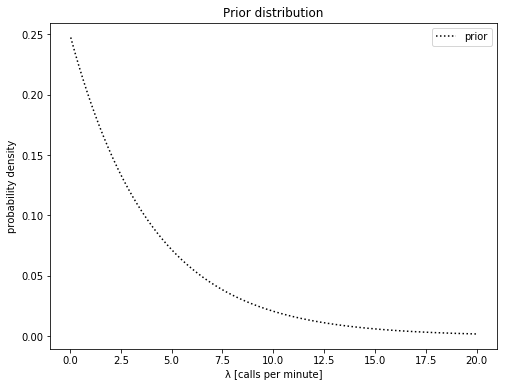

In [143]:
# DEFINE THE PRIOR DISTRIBUTION

# This function takes 1 input, namely the parameter value (λ) at which to
# compute the prior probability density. You need to evaluate the distribution
# Gamma(λ | α, β).

def prior(lambda_):
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)

# PLOT THE PRIOR
lambdas = np.linspace(0, 20, 501)[1:]
plt.figure(figsize=(8, 6))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Prior distribution')
plt.legend()
plt.show()

In [144]:
# DEFINE THE LIKELIHOOD FUNCTION
#
# This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set. You need to evaluate
# the exponential distribution of the datum given the parameter value.

def likelihood(lambda_, datum):
    return sts.expon(scale=1/lambda_).pdf(datum)

# THE POSTERIOR DISTRIBUTION
#
# The function below is provided to help make computing the posterior easier. It
# follows the same pattern as in the previous class, where we multiple the prior
# and the likelihood evaluated at various values of the parameter (λ).
#
# You will see the function uses the logarithms of various distributions. This
# is for numerical reasons. When you multiply lots of likelihood values, the
# result can become very large or very small, causing numerical overflow or
# underflow in Python. Taking logarithms avoids this problem.

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

In [145]:
# Creating a list where I add posterior distributions for every hour
posteriors = []
for i in range(24):
    posteriors.append(compute_posterior(lambdas, prior, likelihood, waiting_times_per_hour[i]))

# Creating a list where I add confidence intervals
conf_ints = [] 
for i in posteriors:
    conf_ints.append([compute_percentile(lambdas, i, p) for p in [0.01, 0.99]])

# In this list I find differences between the upper and lower values of conf ints
# This is required for my errorbar plot 

conf_ints_ = []
for i in range(len(conf_ints)):
    conf_ints_.append(conf_ints[i][1] - conf_ints[i][0])

# Creating a list where I save my posterior means 
posterior_means = []
for i in posteriors:
    posterior_means.append(sp.integrate.trapz(i * lambdas, lambdas))

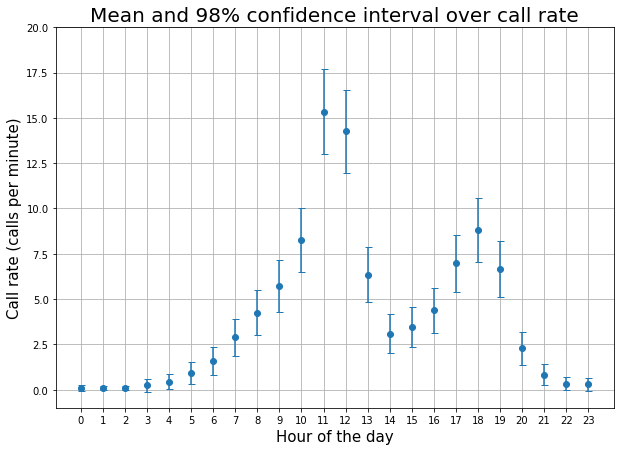

In [152]:
# Plotting the posterior means and 95% confidence intervals

plt.figure(figsize=(10,7))
plt.title('Mean and 98% confidence interval over call rate', size=20)
plt.xlabel('Hour of the day', size=15)
plt.ylabel('Call rate (calls per minute)', size=15)
plt.xticks(np.linspace(0, 23, 24))
plt.grid()
plt.errorbar(np.linspace(0, 23, 24), posterior_means, conf_ints_, fmt='o', capsize=3.5)
plt.ylim([-1, 20])
plt.show()

In [155]:
posterior_means[12]

14.250688383069162